In [1]:
import numpy as np
import matplotlib.pyplot as plt
from labellines import labelLine, labelLines
from simple_tritium_transport_model import Model, ureg, quantity_to_activity


## Model definition

$$ V \frac{d c_\mathrm{salt}}{dt} = S - Q_\mathrm{wall} - Q_\mathrm{top} $$

$$ S = \mathrm{TBR} \cdot \Gamma_n $$
where $\Gamma_n$ is the neutron rate in n/s.

$Q_i$ are the release rate of T permeating through the walls and being released at the top of the salt and are expressed as:
$$ Q_i = A_i \ k_i \ (c_\mathrm{salt} - c_\mathrm{external}) \approx A_i \ k_i \ c_\mathrm{salt}$$
where $A_i$ is the contact surface area, $k_i$ are the mass transfer coefficients.

## Standard BABY run

In [2]:
baby_radius = 1.77 * ureg.inches - 2 * 0.06 * ureg.inches  # from CAD drawings
baby_volume = 0.1 * ureg.L
baby_cross_section = np.pi * baby_radius**2
baby_height = baby_volume / baby_cross_section
baby_model = Model(
    radius=baby_radius,
    height=baby_height,
    TBR=2.94e-4 * ureg.particle * ureg.neutron**-1,  # Stefano's calculation 23rd Feb
)
baby_model.number_days = 2 * ureg.days
baby_model.exposure_time = 12 * ureg.hour
baby_model.neutron_rate = (1.2e8 + 3e8) * ureg.neutron * ureg.s**-1
baby_model.dt = 0.4 * ureg.h
baby_model.run(6 * ureg.day)


C:\Users\remidm\AppData\Roaming\Python\Python311\site-packages\scipy\optimize\_minpack_py.py:222: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  x0 = asarray(x0).flatten()
C:\Users\remidm\AppData\Roaming\Python\Python311\site-packages\scipy\optimize\_minpack_py.py:237: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  retval = _minpack._hybrd(func, x0, args, 1, xtol, maxfev,
C:\Users\remidm\AppData\Roaming\Python\Python311\site-packages\scipy\optimize\_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


C:\Users\remidm\AppData\Roaming\Python\Python311\site-packages\scipy\integrate\_quadrature.py:353: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  y = np.asarray(y)
C:\Users\remidm\AppData\Roaming\Python\Python311\site-packages\scipy\integrate\_quadrature.py:357: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  x = np.asarray(x)


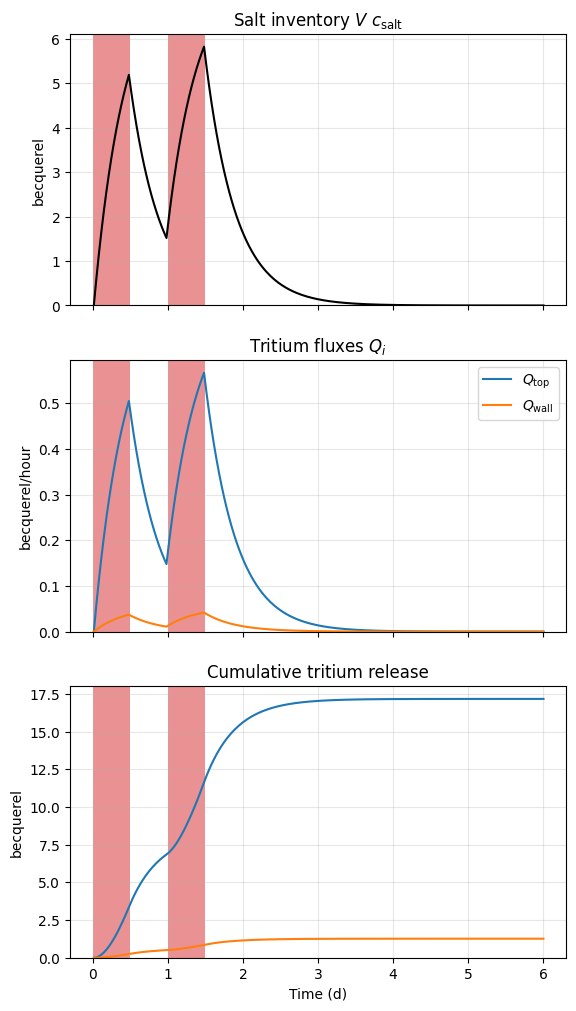

In [3]:
from scipy.integrate import cumulative_trapezoid

time = baby_model.times.to(ureg.day)

fig, (ax_inv, ax_fluxes, ax_cumul) = plt.subplots(3, 1, sharex=True, figsize=(6.4, 12))
plt.sca(ax_inv)
plt.title("Salt inventory $V \ c_\mathrm{salt}$")
plt.plot(
    time,
    quantity_to_activity(baby_model.concentrations * baby_model.volume).to(ureg.Bq),
    color="black",
)

plt.sca(ax_fluxes)
plt.title("Tritium fluxes $Q_i$")
release_top = quantity_to_activity(baby_model.Q_top(baby_model.concentrations)).to(
    ureg.Bq * ureg.s**-1
)
release_top = release_top.to(ureg.Bq * ureg.h**-1)
release_walls = quantity_to_activity(baby_model.Q_wall(baby_model.concentrations)).to(
    ureg.Bq * ureg.s**-1
)
release_walls = release_walls.to(ureg.Bq * ureg.h**-1)
plt.plot(time, release_top, label="$Q_\mathrm{top}$")
plt.plot(time, release_walls, label="$Q_\mathrm{wall}$")
plt.legend()

plt.sca(ax_cumul)
plt.title("Cumulative tritium release")
integrated_top = (
    cumulative_trapezoid(
        release_top.to(ureg.Bq * ureg.h**-1), time.to(ureg.h), initial=0
    )
    * ureg.Bq
)
integrated_wall = (
    cumulative_trapezoid(
        release_walls.to(ureg.Bq * ureg.h**-1), time.to(ureg.h), initial=0
    )
    * ureg.Bq
)
plt.plot(time, integrated_top, label="top")
plt.plot(time, integrated_wall, label="wall")
plt.xlabel(f"Time ({time.units:~P})")

for ax in [ax_inv, ax_fluxes, ax_cumul]:
    ax.set_ylim(bottom=0)
    ax.grid(alpha=0.3)
    for day in range(baby_model.number_days.to(ureg.day).magnitude):
        ax.axvspan(0*ureg.h + day*ureg.day, baby_model.exposure_time+ day*ureg.day, facecolor='tab:red', alpha=0.5)

plt.savefig("basic_model_results.pdf")
plt.show()


## Can we detect tritium in the sweep gas?

This section tries to determine if we can detect T in the sweep gas for a 1L salt volume experiment.

In [4]:
baby_model.exposure_time = 12 * ureg.h
baby_model.dt = baby_model.exposure_time/10
print(f"Salt volume: {baby_model.volume.to(ureg.mL):.2f~P}")
print(f"TBR: {baby_model.TBR.to(ureg.dimensionless):.4f~P}")

baby_model.reset()
baby_model.run(t_final=8*ureg.day)

Salt volume: 100.00 ml
TBR: 0.0003


C:\Users\remidm\AppData\Roaming\Python\Python311\site-packages\scipy\optimize\_minpack_py.py:222: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  x0 = asarray(x0).flatten()
C:\Users\remidm\AppData\Roaming\Python\Python311\site-packages\scipy\optimize\_minpack_py.py:237: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  retval = _minpack._hybrd(func, x0, args, 1, xtol, maxfev,
C:\Users\remidm\AppData\Roaming\Python\Python311\site-packages\scipy\optimize\_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [5]:
wall_release = quantity_to_activity(baby_model.Q_wall(baby_model.concentrations))
top_release = quantity_to_activity(baby_model.Q_top(baby_model.concentrations))

The bubblers + liquid scintillation counting system measures the total quantity of tritium released over time.

C:\Users\remidm\AppData\Roaming\Python\Python311\site-packages\scipy\integrate\_quadrature.py:353: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  y = np.asarray(y)
C:\Users\remidm\AppData\Roaming\Python\Python311\site-packages\scipy\integrate\_quadrature.py:357: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  x = np.asarray(x)
C:\Users\remidm\AppData\Roaming\Python\Python311\site-packages\labellines\utils.py:27: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.asarray(value, dtype=float)


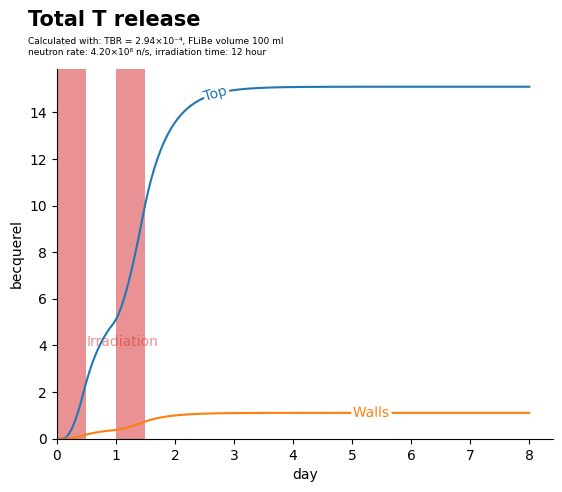

In [6]:
plt.gca().xaxis.set_units(ureg.day)

plt.gcf().text(0.08, 0.97, "Total T release", weight="bold", fontsize=15)
subtitle = [
    f"Calculated with: TBR = {baby_model.TBR.to(ureg.dimensionless):.2e~P}, FLiBe volume {baby_model.volume.to(ureg.ml):.0f~P}",
    f"neutron rate: {baby_model.neutron_rate:.2e~P}, irradiation time: {baby_model.exposure_time}"
]

plt.gcf().text(0.08, 0.91, s="\n".join(subtitle), fontsize=6.5)


integrated_top = (
    cumulative_trapezoid(
        top_release.to(ureg.Bq * ureg.h**-1), baby_model.times.to(ureg.h), initial=0
    )
    * ureg.Bq
)
integrated_wall = (
    cumulative_trapezoid(
        wall_release.to(ureg.Bq * ureg.h**-1), baby_model.times.to(ureg.h), initial=0
    )
    * ureg.Bq
)
plt.plot(baby_model.times.to(ureg.h), integrated_top, label="Top")
plt.plot(baby_model.times.to(ureg.h), integrated_wall, label="Walls")

for day in range(baby_model.number_days.to(ureg.day).magnitude):
    plt.axvspan(0*ureg.h + day*ureg.day, baby_model.exposure_time+ day*ureg.day, facecolor='tab:red', alpha=0.5)
plt.annotate("Irradiation", (baby_model.exposure_time, 4*ureg.Bq), color="tab:red", alpha=0.5)
labelLines(plt.gca().get_lines(), zorder=2.5)
plt.xlim(left=0*ureg.h)
plt.ylim(bottom=0*ureg.Bq)
plt.gca().spines.top.set_visible(False)
plt.gca().spines.right.set_visible(False)

C:\Users\remidm\AppData\Roaming\Python\Python311\site-packages\labellines\core.py:148: UserWarning: Tried to label line Line2D(_child2), but could not find a label for it.
  warnings.warn(


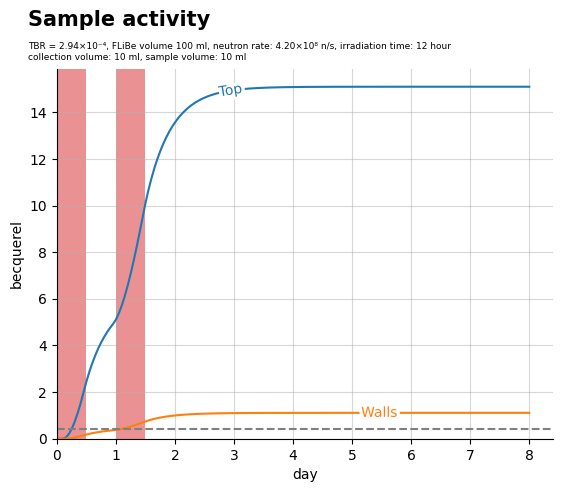

In [7]:
COLLECTION_VOLUME = 10 * ureg.ml
LSC_SAMPLE_VOLUME = 10 * ureg.ml

plt.gca().xaxis.set_units(ureg.day)
plt.gca().yaxis.set_units(ureg.Bq)


plt.gcf().text(0.08, 0.97, "Sample activity", weight="bold", fontsize=15)
subtitle = [
    f"TBR = {baby_model.TBR.to(ureg.dimensionless):.2e~P}, FLiBe volume {baby_model.volume.to(ureg.ml):.0f~P}, neutron rate: {baby_model.neutron_rate:.2e~P}, irradiation time: {baby_model.exposure_time}",
    f"collection volume: {COLLECTION_VOLUME:.0f~P}, sample volume: {LSC_SAMPLE_VOLUME:.0f~P}"
]
plt.gcf().text(0.08, 0.9, s="\n".join(subtitle), fontsize=6.5)

plt.plot(
    baby_model.times.to(ureg.h),
    integrated_top / COLLECTION_VOLUME * LSC_SAMPLE_VOLUME,
    label="Top",
)
plt.plot(
    baby_model.times.to(ureg.h),
    integrated_wall / COLLECTION_VOLUME * LSC_SAMPLE_VOLUME,
    label="Walls",
)

plt.axhline(y=0.4 * ureg.Bq, color="tab:grey", linestyle="dashed")

for day in range(baby_model.number_days.to(ureg.day).magnitude):
    plt.axvspan(
        0 * ureg.h + day * ureg.day,
        baby_model.exposure_time + day * ureg.day,
        facecolor="tab:red",
        alpha=0.5,
    )

plt.xlim(left=0 * ureg.h)
plt.ylim(bottom=0)
labelLines(plt.gca().get_lines(), zorder=2.5)
plt.gca().spines.top.set_visible(False)
plt.gca().spines.right.set_visible(False)
plt.grid(alpha=0.5)


## Influence of the wall on the global mass transport coefficient

We now try to derive an analytical expression for the mass transport coefficient of T from the salt bulk to the metallic wall.

- $Q$ the overall tritium permeation flux from the salt to the sweep gas
- $k_\mathrm{salt}$ the mass transport coefficient from the salt bulk to the metallic wall
- $A$ the surface area of the salt-metal interface
- $e$ metal thickness
- $c_\mathrm{salt}$ bulk salt concentration
- $c_\mathrm{S, int}$ salt concentration at the salt-metal interface
- $c_\mathrm{M, int}$ metal concentration at the salt-metal interface
- $D_\mathrm{M}$ metal diffusivity
- $K_\mathrm{M}$ metal solubility
- $D_\mathrm{S}$ salt diffusivity

In [8]:
import sympy as sp

Q = sp.Symbol("Q")
k = sp.Symbol("k_\mathrm{salt}")
A = sp.Symbol("A")
c_salt = sp.Symbol("c_\mathrm{salt}")
c_sint = sp.Symbol("c_\mathrm{S, int}")
c_mint = sp.Symbol("c_\mathrm{M, int}")
e = sp.Symbol("e")
D_M = sp.Symbol("D_\mathrm{M}")
K_M = sp.Symbol("K_\mathrm{M}")
K_S = sp.Symbol("K_\mathrm{S}")

The flux from the salt bulk to the salt-metal interface can be expressed as:

In [9]:
flux_salt_to_interface = sp.Eq(Q, k*A * (c_salt - c_sint))
flux_salt_to_interface

Eq(Q, A*k_\mathrm{salt}*(-c_\mathrm{S, int} + c_\mathrm{salt}))

Assuming the concentration at the metal-gas interface is zero, the flux through the metal layer is:

In [10]:
flux_interface_to_gas = sp.Eq(Q, A * D_M * c_mint / e)
flux_interface_to_gas

Eq(Q, A*D_\mathrm{M}*c_\mathrm{M, int}/e)

At the salt-metal interface, the conservation of chemical potential gives:

In [11]:
conservation_chemical_pot_interface = sp.Eq((c_sint/K_S), (c_mint/K_M)**2)
conservation_chemical_pot_interface

Eq(c_\mathrm{S, int}/K_\mathrm{S}, c_\mathrm{M, int}**2/K_\mathrm{M}**2)

Solving these three equations for $k$, $c_\mathrm{S, int}$, and $c_\mathrm{M, int}$, we can express $k_\mathrm{salt}$:

In [12]:
balance_of_flux = sp.Eq(flux_salt_to_interface.rhs, flux_interface_to_gas.rhs)

In [13]:
res = sp.solve(
    [
        balance_of_flux,
        conservation_chemical_pot_interface,
    ],
    [c_mint, c_sint],
    dict=True,
)
sp.Eq(c_sint, res[0][c_sint].simplify())

Eq(c_\mathrm{S, int}, (D_\mathrm{M}**2*K_\mathrm{M}**2 - D_\mathrm{M}*K_\mathrm{M}*sqrt(D_\mathrm{M}**2*K_\mathrm{M}**2 + 4*K_\mathrm{S}*c_\mathrm{salt}*e**2*k_\mathrm{salt}**2) + 2*K_\mathrm{S}*c_\mathrm{salt}*e**2*k_\mathrm{salt}**2)/(2*K_\mathrm{S}*e**2*k_\mathrm{salt}**2))

In [14]:
sp.Eq(c_salt/c_sint, (c_salt/res[0][c_sint]).simplify())

Eq(c_\mathrm{salt}/c_\mathrm{S, int}, 2*K_\mathrm{S}*c_\mathrm{salt}*e**2*k_\mathrm{salt}**2/(D_\mathrm{M}**2*K_\mathrm{M}**2 - D_\mathrm{M}*K_\mathrm{M}*sqrt(D_\mathrm{M}**2*K_\mathrm{M}**2 + 4*K_\mathrm{S}*c_\mathrm{salt}*e**2*k_\mathrm{salt}**2) + 2*K_\mathrm{S}*c_\mathrm{salt}*e**2*k_\mathrm{salt}**2))

It can be shown that $$\frac{c_\mathrm{salt}}{c_\mathrm{S, int}} \gg 1$$ is equivalent to $$1 + \frac{D \ K_\mathrm{M}}{e\ k_\mathrm{salt} \ \sqrt{K_\mathrm{S}\ c_\mathrm{salt}} } \gg 1$$ $$W \gg 1$$

In [15]:
def W_number(c_salt, D_M, K_M, K_S, k_wall, e):
    return 1 + D_M * K_M / (e * k_wall * (K_S * c_salt)**0.5)

c_salt = max(baby_model.concentrations)
Q = baby_model.Q_wall(c_salt)
A = baby_model.A_wall
e = baby_model.L_wall
k_wall = 1.9e-8 * ureg.m * ureg.s**-1  # from Kumagai

# properties (OoM) for Inconel 600, Tungsten, and FLiBe at 700K
properties = {
    "tungsten": {"D": 1e-11 * ureg.m**2 * ureg.s**-1, "K_M": 1e20 * ureg.particle * ureg.m**-3 * ureg.Pa**-0.5},
    "inconel": {"D": 1e-10 * ureg.m**2 * ureg.s**-1, "K_M": 1e22 * ureg.particle * ureg.m**-3 * ureg.Pa**-0.5},
}

K_S = 1e19* ureg.particle * ureg.m**-3 * ureg.Pa**-1

for mat, props in properties.items():
    number = W_number(c_salt, props["D"], props["K_M"], K_S, k_wall, e).to(ureg.dimensionless)

    print(f"{mat} wall: W={number:.2e~P}")

tungsten wall: W=1.94×10³
inconel wall: W=1.94×10⁶


Having $\frac{c_\mathrm{salt}}{c_\mathrm{S, int}} \gg 1$ also implies that the value of the overall flux is only dependent on $k_\mathrm{salt}$ and $c_\mathrm{salt}$

In [16]:
def c_mi(c_inf, D, e, k, K_H, K_S):
    num = -D/e + ((D/e)**2 + 4*k**2 * (K_H/K_S**2) * c_inf)**0.5
    den = 2*k*K_H/K_S**2
    return num/den

def c_si(c_inf, D, e, k, K_H, K_S):
    return c_mi(c_inf, D, e, k, K_H, K_S)**2 * K_H/K_S**2

def flux(c_inf, D, e, k, K_H, K_S):
    return c_mi(c_inf, D, e, k, K_H, K_S) * D / e

for mat, props in properties.items():
    flux_value = flux(max(baby_model.concentrations), props["D"], e, k_wall, K_H=K_S, K_S=props["K_M"]).to(ureg.particle * ureg.m**-2 * ureg.s**-1)
    print(f"{mat} wall: {flux_value: .4e~P}")
print(f"Approximation: {k_wall * max(baby_model.concentrations):.4e~P}")


tungsten wall: 6.0306e+05 particle/m²/s
inconel wall: 6.0311e+05 particle/m²/s
Approximation: 6.0306×10⁵ particle/m²/s


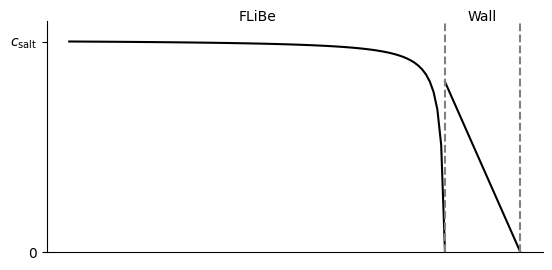

In [17]:
x1 = np.linspace(0, 1, num=100, endpoint=True)
x_end = 1.2
x2 = np.linspace(1, x_end)
y1 = -1/(1.01 - x1) + 100
a2 = -400
b2 = -a2*x_end
y2 = a2 * x2 + b2

plt.figure(figsize=(6.4, 3))
plt.plot(x1, y1, color="black")
plt.plot(x2, y2, color="black")
plt.axvline(x=1, linestyle="dashed", color="grey")
plt.axvline(x=x_end, linestyle="dashed", color="grey")
plt.ylim(bottom=0, top=y1[0]*1.1)
plt.xticks([])
plt.yticks([0, y1[0]], [0, "$c_\mathrm{salt}$"])
plt.gca().spines.top.set_visible(False)
plt.gca().spines.right.set_visible(False)
plt.annotate("Wall", (1.1, y1[0]*1.1), ha="center")
plt.annotate("FLiBe", (0.5, y1[0]*1.1), ha="center")
plt.savefig("tritium_concentration_profile_sketch.pdf")
plt.show()


The assumption is valid and we can safely neglect the contribution of the wall to the overall mass transport resistance.

Note: the uncertainty associated with the salt solubility doesn't invalidate the assumption since the ratio would still be orders of magnitude lower than unity.

# Conclusions

- This model can describe the tritium transport dynamics in BABY (and LIBRA)
- The resistance of the metal wall (Inconel or Tungsten) to the mass transfer is negligible